## Tellus API Example

### Tellus API

[Tellus API リファレンス](https://www.tellusxdp.com/ja/dev/api)

* OpenStreatMap  
  ```GET https://gisapi.tellusxdp.com/osm/{z}/{x}/{y}.png```
* ASNARO-1  
  ```GET https://gisapi.tellusxdp.com/ASNARO-1/{scene_id}_AS1/{z}/{x}/{y}.png```
* PALSAR-2  
  ```GET https://gisapi.tellusxdp.com/PALSAR-2/ALOS{scene_id}/{z}/{x}/{y}.png```
* Landsat-8  
  ```GET https://gisapi.tellusxdp.com/landsat8/{z}/{x}/{y}.png```
* AVNIR-2  
  ```GET  https://gisapi.tellusxdp.com/blend/{z}/{x}/{y}.png?opacity=1&r=4&g=3&b=2&rdepth=1&gdepth=1&bdepth=1&preset=ndvi```

In [1]:
class Tellus:
    def __init__(self, bearer, domain="gisapi.tellusxdp.com", z=0, x=0, y=0):
        self.domain = domain
        self.bearer = bearer
        self.z = z
        self.x = x
        self.y = y
        
    """
    # 指定したタイル(x,y,z)の北端緯度、西端経度を求める

    西端経度は、
    lon(x,z)=((x*W(z)/(2*π*R))*360-180
　          =((x*(2*π*R)/2^z/(2*π*R))*360-180
　          =(x/2^z)*360-180

    北端緯度は、まず投影後の座標mapyを求め、
        mapy=(y / 2 ^ z) * 2 * π- π
    メルカトル投影の逆変換を行って求めます。
        lat(y,z)=2 * atn(e^(-mapy)) * 180 / π - 90
    """
    def latlon(self, z=None, x=None, y=None):
        z_ = z if z is not None else self.z
        x_ = x if x is not None else self.x
        y_ = y if y is not None else self.y

        # 緯度
        from math import pi, atan, e
        y_ = (y_ / 2.0**z_) * 2 * pi - pi
        lat_ = 2 * atan(e ** (-1 * y_)) * 180 / pi - 90
        
        # 経度
        lon_ = (x_ / 2.0**z_) * 360 - 180
        
        return lat_, lon_
    
    def scene_id(self, form="asnaro1", z=None, x=None, y=None):
        if form not in ["asnaro1"]:
            return

        uris = {
            "asnaro1":"https://gisapi.tellusxdp.com/api/v1/asnaro1/scene"
        }

        import requests
        z_ = z if z is not None else self.z
        x_ = x if x is not None else self.x
        y_ = y if y is not None else self.y
        uri_ = uris[form]
        min_lat_, min_lon_ = self.latlon(z=z_, x=x_, y=y_)
        max_lat_, max_lon_ = self.latlon(z=z_, x=x_+1, y=y_+1)
        res_ = requests.get(uri_,
                            params={'min_lat':min_lat_,'min_lon':min_lon_,'max_lat':max_lat_,'max_lon':max_lon_},
                            headers={"Authorization": "Bearer " + self.bearer})
        
        import json
        return res_.json()
    
    def reset(self, z=0, x=0, y=0):
        self.z = z
        self.x = x
        self.y = y

    def zoom_in(self, x=0, y=0):
        if x not in [0, 1] or y not in [0, 1]:
            return

        self.x *= 2
        self.y *= 2

        self.z += 1
        self.x += x
        self.y += y

    def get(self, form, scene_id=None, z=None, x=None, y=None, query=None):
        if query is None:
            query = ""
        else:
            query = "?" + query
            
        z_ = z if z is not None else self.z
        x_ = x if x is not None else self.x
        y_ = y if y is not None else self.y
        
        if form in ["osm", "landsat8", "blend"]:
            uri_ = "https://{}/{}/{}/{}/{}.png{}".format(self.domain, form, z_, x_, y_, query)
        elif form in ["asnaro1"]:
            uri_ = "https://{}/ASNARO-1/{}/{}/{}/{}.png".format(self.domain, scene_id, z_, x_, y_)
        else:
            return
        
        import requests
        res_ = requests.get(uri_, headers={"Authorization": "Bearer " + self.bearer})
        if res_.status_code != 200:
            print(res_.status_code, uri_)
            return

        import numpy
        from PIL import Image
        from io import BytesIO
        image_ = Image.open(BytesIO(res_.content))
        if image_.mode == "P":
            image_ = image_.convert('RGB')
        return numpy.asarray(image_)

In [2]:
def show(image):
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.imshow(image)
    plt.show()

### Tellus インスタンス

APIトークンを [Tellus](https://www.tellusxdp.com/ja/) >> [マイページ](https://www.tellusxdp.com/ja/mypage/email) >> [ＡＰＩアクセス設定](https://www.tellusxdp.com/ja/mypage/clients) から取得する。

In [3]:
BEARER_TOKEN = "********"

APIトークン設定

In [4]:
tellus = Tellus(BEARER_TOKEN)

### タイル座標

京都のタイル座標を確認してみる

参考：[タイル座標確認ツール](http://gsj-seamless.jp/labs/tools/tileCoord.html) で直接確認できる

z:0 x:0 y:0
(85.05112877980659, -180.0)


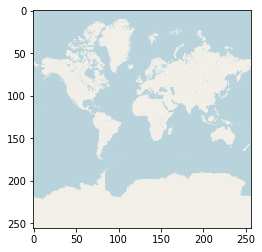

z:13 x:7185 y:3244
(35.02999636902565, 135.7470703125)


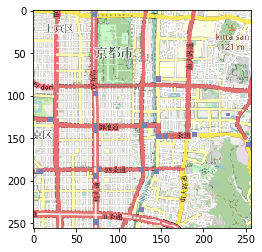

In [5]:
tellus.reset()

print("z:{} x:{} y:{}".format(tellus.z, tellus.x, tellus.y))
print(tellus.latlon())
show(tellus.get("osm"))

tellus.zoom_in(x=1)
tellus.zoom_in(x=1, y=1)
tellus.zoom_in(x=1, y=1)
tellus.zoom_in(x=0, y=0)
tellus.zoom_in(x=0, y=0)
tellus.zoom_in(x=0, y=1)
tellus.zoom_in(x=0, y=0)
tellus.zoom_in(x=0, y=1)
tellus.zoom_in(x=1, y=0)
tellus.zoom_in(x=0, y=1)
tellus.zoom_in(x=0, y=1)
tellus.zoom_in(x=0, y=0)
tellus.zoom_in(x=1, y=0)

print("z:{} x:{} y:{}".format(tellus.z, tellus.x, tellus.y))
print(tellus.latlon())
show(tellus.get("osm"))

### AVNIR-2
AVNIR-2(高性能可視近赤外放射計2型)画像を取得してみる。

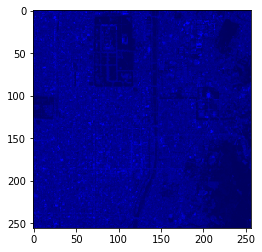

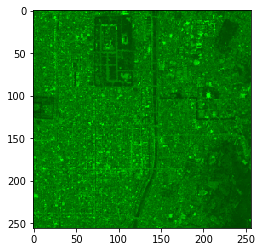

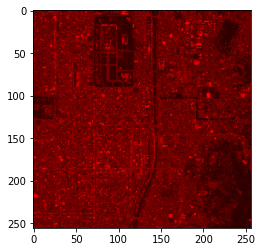

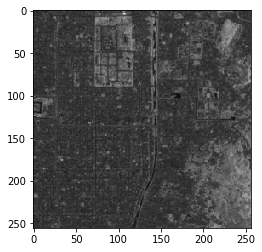

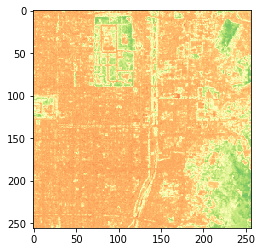

In [6]:
show(tellus.get("blend", query="r=3&g=2&b=1&rdepth=0&gdepth=0")) # 青
show(tellus.get("blend", query="r=3&g=2&b=1&bdepth=0&rdepth=0")) # 緑
show(tellus.get("blend", query="r=3&g=2&b=1&gdepth=0&bdepth=0")) # 赤
show(tellus.get("blend", query="r=4&g=4&b=4")) # 近赤外
show(tellus.get("blend", query="preset=ndvi")) # NVDI

### ASNARO-1
ASNARO-1画像を取得してみる。

In [ ]:
for s in tellus.scene_id():
    print(s["acquisitionDate"])
    show(tellus.get("asnaro1", scene_id=s["entityId"]))